In [ ]:
import os
import time
import random
import math
import re
import sys
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from osgeo import gdal, ogr, osr

from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
NLCD_CLASSES = [ 0, 11, 12, 21, 22, 23, 24, 31, 41, 42, 43, 52, 71, 81, 82, 90, 95] # 16 classes + 1 nodata class ("0").
NUM_DFC2021_CLASS = 5 # Output classes (0: Water, 1: Tree Canopy, 2: Low Vegetation , 3: Impervious, 4: None)
SEED_NUM = 3
NLCD_IDX_TO_REDUCED_LC_MAP = np.array([
    4,#  0 No data 0
    0,#  1 Open Water
    4,#  2 Ice/Snow
    2,#  3 Developed Open Space
    3,#  4 Developed Low Intensity
    3,#  5 Developed Medium Intensity
    3,#  6 Developed High Intensity
    3,#  7 Barren Land
    1,#  8 Deciduous Forest
    1,#  9 Evergreen Forest
    1,# 10 Mixed Forest
    1,# 11 Shrub/Scrub
    2,# 12 Grassland/Herbaceous
    2,# 13 Pasture/Hay
    2,# 14 Cultivated Crops
    1,# 15 Woody Wetlands
    1,# 16 Emergent Herbaceious Wetlands
])

# Data Preparation

In [ ]:
def store_np_and_png(nlcd_path, hr_label_path, output_path, image_id_year):
    """
    Please export the high-res label(s) from GroundWork using "export data" tab.
    You only need to select the check-box of tile layer for the image options.
    Then you can DL catalog.zip from GroundWork.
    In this function, you will import the geojason file where high-res label data are stored.
    We also import the original NLCD low-res label, but this is only to get the size of the *label*.
    
    Note that we need to at least label the upper left and the lower right corner of the original NAIP image,
    because the largest and smallest coordinates are required to accurately transform to a png image file.

    Input:
        nlcd_path: File path of the downloaded NLCD image
        hr_label_path: File path of the exported label data (/catalog/labels/data/xxx.geojson) from GroundWork
        output_path: Folder path to save outputs
        image_id_year: 'Image_file_ID + "_" + year' to name outputs

    Output:
        image_gray_np: np.array of high-resolution label in gray scale
        image: rgb image with three channels (light blue: Water, dark green: Tree Canopy, light green: Low Vegetation, red: Impervious).
               Use this to visually check the curated high-res label
        image_gray: gray-scale image with only one channel (0: Water, 1: Tree Canopy, 2: Low Vegetation, 3: Impervious).
                Note that these are the same with Codalab https://codalab.lisn.upsaclay.fr/competitions/7908). Use this to test our models
    """
    import sys
    from osgeo import gdal,ogr,osr
    import matplotlib.pyplot as plt
    from PIL import Image, ImageDraw
    import json
    import pandas as pd
    import numpy as np
    import re

    def calc_map_LonLat(nlcd_path):
        def intermidiate_calc(extracted_xy):
            ms  = re.search('\..*"',  extracted_xy).group()[1:-1]
            sec = re.search('\'.*\.', extracted_xy).group()[1:-1]
            min = re.search('d.*\'',  extracted_xy).group()[1:-1]
            deg = re.search('.*d',    extracted_xy).group()[0:-1]
            return(int(deg) + int(min) / 60 + int(sec) / 3600 + int(ms) / 3600000)
        
        def calc_mapXY(extracted_UL_LR):
            mapX = - intermidiate_calc(re.search('\).*W', extracted_UL_LR).group()[3:-1])
            mapY =   intermidiate_calc(re.search('W,.*N', extracted_UL_LR).group()[2:-1])
            return(mapX, mapY)

        txt = gdal.Info(nlcd_path)
        extracted_UL = re.search('Upper Left.*\nLower Left', txt).group()
        extracted_LR = re.search('Lower Right.*\nCenter', txt).group()
        _mapXmin_, _mapYmax_ = calc_mapXY(extracted_UL)
        _mapXmax_, _mapYmin_ = calc_mapXY(extracted_LR)

        return(_mapXmin_, _mapYmax_, _mapXmax_, _mapYmin_)

    def make_save_image_np(nlcd_path, hr_label_path, output_path, image_id_year):
        # Open the data source and read in the extent
        data_source = ogr.Open(hr_label_path)
        if data_source is None:
            print ('Could not open file')
            sys.exit(1)

        mapXmin, mapXmax, mapYmin, mapYmax = data_source.GetLayer().GetExtent()
        # http://gdal.org/python/osgeo.ogr.Layer-class.html#GetExtent

        _mapXmin_, _mapYmax_, _mapXmax_, _mapYmin_ = calc_map_LonLat(nlcd_path)

        print("X and Y-coordinates are longitude and latitude respectively",
              "\nmapXmin: ", mapXmin, "\nmapXmax: ", mapXmax, "\nmapYmin: ", mapYmin, "\nmapYmax: ", mapYmax,
              "\n\nfrom corresponding NLCD",
              "\nmapXmin: ", _mapXmin_, "\nmapXmax: ", _mapXmax_, "\nmapYmin: ", _mapYmin_, "\nmapYmax: ", _mapYmax_,
              "\nNote that it seems to be better to use the one from the exported high-res label from GroundWork",
              "\n\nW:", mapXmax - mapXmin, "\nH:", mapYmax - mapYmin)

        # Define pixel_size 
        # pixel_size = 0.5 # meters are one pixel
        # Create the target data source
        gdal_nlcd = gdal.Open(nlcd_path, gdal.GA_ReadOnly)
        target_Width = gdal_nlcd.RasterXSize
        target_Height = gdal_nlcd.RasterYSize

        pixel_size_x = abs(mapXmax - mapXmin) / target_Width
        pixel_size_y = abs(mapYmax - mapYmin) / target_Height
        print("pixel_size_x:", pixel_size_x, "\npixel_size_y:", pixel_size_y)

        image_TC = Image.new('RGB', (target_Width, target_Height))
        image_gray_TC = Image.new('L', (target_Width, target_Height))
        image_Im = Image.new('RGB', (target_Width, target_Height))
        image_gray_Im = Image.new('L', (target_Width, target_Height))
        image_W = Image.new('RGB', (target_Width, target_Height))
        image_gray_W = Image.new('L', (target_Width, target_Height))
        image_LV = Image.new('RGB', (target_Width, target_Height))
        image_gray_LV = Image.new('L', (target_Width, target_Height))

        draw_TC = ImageDraw.Draw(image_TC)
        draw_gray_TC = ImageDraw.Draw(image_gray_TC)
        draw_Im = ImageDraw.Draw(image_Im)
        draw_gray_Im = ImageDraw.Draw(image_gray_Im)
        draw_W = ImageDraw.Draw(image_W)
        draw_gray_W = ImageDraw.Draw(image_gray_W)
        draw_LV = ImageDraw.Draw(image_LV)
        draw_gray_LV = ImageDraw.Draw(image_gray_LV)

        # Loop through the features in the layer
        json_source = json.load(open(hr_label_path))
        for ftr in json_source.get('features'):
            att = ftr.get('properties')['default']

            for multipolygon in ftr['geometry']['coordinates']: #4D coordata
                for ply in multipolygon:
                    ply = np.array(ply)
                    loc = np.argmax(ply[:, 0])
                    v1 = ply[loc] - ply[loc - 1]
                    v2 = ply[loc + 1] - ply[loc - 1]

                    ply = (ply - [mapXmin, mapYmax]) * [1, -1] / [pixel_size_x, pixel_size_y]
                    ply = [(a[0], a[1]) for a in ply.tolist()]

                    if v1[0] * v2[1] - v1[1] * v2[0] >= 0:
                        if(att == 'Tree Canopy'):
                            color = (0, 128, 0); color2 = 1 #dark green
                            draw_TC.polygon(ply, fill = color, outline = None)
                            draw_gray_TC.polygon(ply, fill = color2, outline = None)
                        elif(att == 'Impervious'):
                            color = (255, 0, 0); color2 = 3 #red
                            draw_Im.polygon(ply, fill = color, outline = None)
                            draw_gray_Im.polygon(ply, fill = color2, outline = None)
                        elif(att == 'Water'):
                            color = (0, 225, 225); color2 = 0 #light blue
                            draw_W.polygon(ply, fill = color, outline = None)
                            draw_gray_W.polygon(ply, fill = color2, outline = None)
                        elif(att == 'Low Vegetation'):
                            color = (0, 255, 0); color2 = 2 #light green
                            draw_LV.polygon(ply, fill = color, outline = None)
                            draw_gray_LV.polygon(ply, fill = color2, outline = None)
                        else: raise ValueError('Wrong target class!')
                    else:
                        if(att == 'Tree Canopy'):
                            draw_TC.polygon(ply, fill = (0, 0, 0), outline = None)
                            draw_gray_TC.polygon(ply, fill = 0, outline = None)
                        elif(att == 'Impervious'):
                            draw_Im.polygon(ply, fill = (0, 0, 0), outline = None)
                            draw_gray_Im.polygon(ply, fill = 0, outline = None)
                        elif(att == 'Water'):
                            draw_W.polygon(ply, fill = (0, 0, 0), outline = None)
                            draw_gray_W.polygon(ply, fill = 0, outline = None)
                        elif(att == 'Low Vegetation'):
                            draw_LV.polygon(ply, fill = (0, 0, 0), outline = None)
                            draw_gray_LV.polygon(ply, fill = 0, outline = None)
                        else: raise ValueError('Wrong target class!')

        image_TC_np = np.array(image_TC)
        image_Im_np = np.array(image_Im)
        image_W_np = np.array(image_W)
        image_LV_np = np.array(image_LV)
        image_gray_TC_np = np.array(image_gray_TC)
        image_gray_Im_np = np.array(image_gray_Im)
        image_gray_W_np = np.array(image_gray_W)
        image_gray_LV_np = np.array(image_gray_LV)

        #prioritize in order of Im ->  LV ->  TC ->  W
        image_LV_np[np.sum(image_Im_np, axis = -1) > 0, :] = 0
        image_TC_np[np.sum(image_Im_np, axis = -1) > 0, :] = 0
        image_W_np[np.sum(image_Im_np, axis = -1) > 0, :] = 0
        image_gray_LV_np[image_gray_Im_np > 0] = 0
        image_gray_TC_np[image_gray_Im_np > 0] = 0
        image_gray_W_np[image_gray_Im_np > 0] = 0

        image_TC_np[np.sum(image_LV_np, axis = -1) > 0, :] = 0
        image_W_np[np.sum(image_LV_np, axis = -1) > 0, :] = 0
        image_gray_TC_np[image_gray_LV_np > 0] = 0
        image_gray_W_np[image_gray_LV_np > 0] = 0

        image_W_np[np.sum(image_TC_np, axis = -1) > 0, :] = 0
        image_gray_W_np[image_gray_TC_np > 0] = 0

        image_np = image_TC_np + image_Im_np + image_W_np + image_LV_np
        image_gray_np = image_gray_TC_np + image_gray_Im_np + image_gray_W_np + image_gray_LV_np
        np.save(output_path + "image_rgb-" + image_id_year, image_np)
        np.save(output_path + "image_gray-" + image_id_year, image_gray_np)

        return(image_np, image_gray_np)

    
    image_np, image_gray_np = make_save_image_np(nlcd_path, hr_label_path, output_path, image_id_year)
    image = Image.fromarray(image_np)
    image_gray = Image.fromarray(image_gray_np)

    print(f'\nsize of image: {image.size}', f'\nsize of image_gray: {image_gray.size}',
          f'\nsize of image -- rbg: {image_np.shape} as numpy array',
          f'\nsize of image_gray -- gray-scale: {image_gray_np.shape} as numpy array')
    print('\n---Distribution-------------------',
          '\n0: Water', '\n1: Tree Canopy', '\n2: Low Vegetation', '\n3: Impervious\n\n',
          pd.Series(image_gray_np.flatten()).value_counts())

    gdal_nlcd = gdal.Open(nlcd_path, gdal.GA_ReadOnly)
    nlcd_np = np.array([gdal_nlcd.GetRasterBand(i + 1).ReadAsArray() for i in range(gdal_nlcd.RasterCount)])

    fig, ax = plt.subplots(1, 3, figsize = (15, 5))
    ax[0].imshow(image)
    ax[0].set_title("high-res label (rgb)")
    ax[1].imshow(image_gray, cmap = 'gray')
    ax[1].set_title("high-res label (gray-scale)")
    ax[2].imshow(nlcd_np[0], cmap = 'gray')
    ax[2].set_title("NLCD low-res label (gray-scale)")
    plt.show()

    image.save(output_path + "image_rgb-" + image_id_year + '.png')
    image.save(output_path + "image_gray-" + image_id_year + '.png')

--2022-10-21 20:40:02--  https://dfc2021.blob.core.windows.net/competition-data/nlcd-2013/3716_nlcd-2013.tif
Resolving dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)... 52.239.169.100
Connecting to dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)|52.239.169.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 666610 (651K) [application/octet-stream]
Saving to: ‘/content/3716_nlcd-2013.tif’

3716_nlcd-2013.tif  100%[===================>] 650.99K   469KB/s    in 1.4s    

2022-10-21 20:40:04 (469 KB/s) - ‘/content/3716_nlcd-2013.tif’ saved [666610/666610]

X and Y-coordinates are longitude and latitude respectively 
mapXmin:  -76.4506484 
mapXmax:  -76.4057326 
mapYmin:  38.2183346 
mapYmax:  38.25361459999999 

from corresponding NLCD 
mapXmin:  -76.45056472222223 
mapXmax:  -76.40557333333334 
mapYmin:  38.218333333333334 
mapYmax:  38.25361138888889 
Note that it seems to be better to use the one from the exported high-res label fro

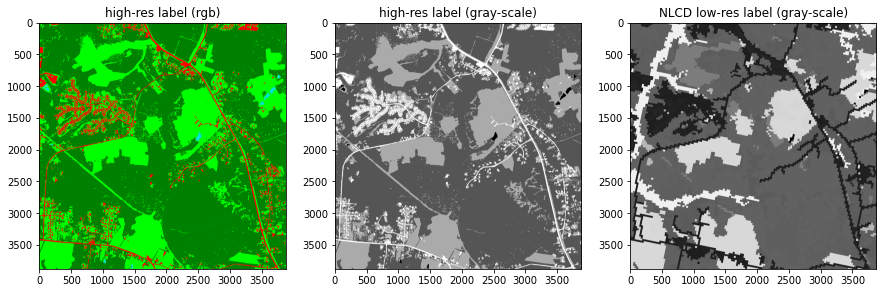

In [ ]:
# URL of the corresponding NLCD image.
!wget -P /content https://dfc2021.blob.core.windows.net/competition-data/nlcd-2013/3716_nlcd-2013.tif

store_np_and_png(nlcd_path = '/content/3716_nlcd-2013.tif', # File path of the downloaded NLCD image
                 hr_label_path = '/content/drive/MyDrive/Columbia/JPMC3-2/test_label_hr/3716_hr_label-2013.geojson',
                 # File path of the exported label (/catalog/labels/data/xxx.geojson) from GroundWork

                 output_path = "/content/drive/MyDrive/Columbia/JPMC3-2/test_label_hr/", image_id_year = "3716_2013")

--2022-10-21 20:40:20--  https://dfc2021.blob.core.windows.net/competition-data/nlcd-2016/3716_nlcd-2016.tif
Resolving dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)... 52.239.169.100
Connecting to dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)|52.239.169.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 672621 (657K) [application/octet-stream]
Saving to: ‘/content/3716_nlcd-2016.tif’

3716_nlcd-2016.tif  100%[===================>] 656.86K   416KB/s    in 1.6s    

2022-10-21 20:40:22 (416 KB/s) - ‘/content/3716_nlcd-2016.tif’ saved [672621/672621]

X and Y-coordinates are longitude and latitude respectively 
mapXmin:  -76.4506484 
mapXmax:  -76.4057326 
mapYmin:  38.2183346 
mapYmax:  38.25361459999999 

from corresponding NLCD 
mapXmin:  -76.45056472222223 
mapXmax:  -76.40557333333334 
mapYmin:  38.218333333333334 
mapYmax:  38.25361138888889 
Note that it seems to be better to use the one from the exported high-res label fro

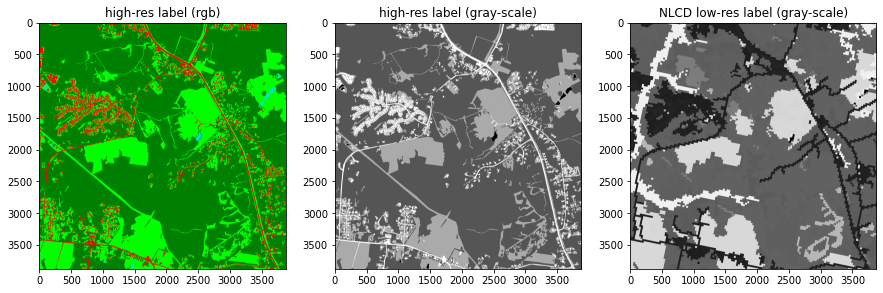

In [ ]:
# URL of the corresponding NLCD image.
!wget -P /content https://dfc2021.blob.core.windows.net/competition-data/nlcd-2016/3716_nlcd-2016.tif

store_np_and_png(nlcd_path = '/content/3716_nlcd-2016.tif', # File path of the downloaded NLCD image
                 hr_label_path = '/content/drive/MyDrive/Columbia/JPMC3-2/test_label_hr/3716_hr_label-2017.geojson',
                 # File path of the exported label (/catalog/labels/data/xxx.geojson) from GroundWork

                 output_path = "/content/drive/MyDrive/Columbia/JPMC3-2/test_label_hr/", image_id_year = "3716_2017")

In [ ]:
!wget --quiet -P /content/data/test_image https://dfc2021.blob.core.windows.net/competition-data/naip-2013/3716_naip-2013.tif
!wget --quiet -P /content/data/test_image https://dfc2021.blob.core.windows.net/competition-data/naip-2017/3716_naip-2017.tif

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Columbia/JPMC3-2/training_set_naip_nlcd_both.csv')

num_we_select = 128    # Roughly 60M * num_we_select size is required!!

In [ ]:
random.seed(SEED_NUM)

os.makedirs('/content/data', exist_ok = True)

!rm -rf /content/data/image/*
!rm -rf /content/data/label/*

ris_dl = random.sample(range(len(df)), k = num_we_select)
df_dl = df.iloc[ris_dl]  

df_dl['image_fn'].to_csv('/content/data/image_fns.txt', header = False, index = False)
df_dl['label_fn'].to_csv('/content/data/label_fns.txt', header = False, index = False)

start_time = time.time()
!wget --quiet -P /content/data/image -i /content/data/image_fns.txt
!wget --quiet -P /content/data/label -i /content/data/label_fns.txt
(time.time() - start_time) / 60

24.28547292947769

# Visualization of training NAIP images and NLCD labels

In [ ]:
"""
n_row = 2
n_col = math.ceil(num_we_select / n_row)
fig, axes = plt.subplots(n_row, n_col, figsize = (15, 15 * n_row / n_col))
for i, file in enumerate(sorted(
    [file for file in os.listdir('/content/data/image/') 
    if file.endswith('.tif')])):
    searched = re.search('\d+_', file)
    map_id = searched.group()[:-1]
    row = i // n_col
    col = i % n_col
    ds = gdal.Open(os.path.join('/content/data/image/', file), gdal.GA_ReadOnly)
    train_image_np = np.array([ds.GetRasterBand(i + 1).ReadAsArray() for i in range(ds.RasterCount)])
    axes[row, col].imshow(np.transpose(train_image_np, (1,2,0))[:, :, :3])
    axes[row, col].set_title(f'image {map_id}')
plt.show()

fig, axes = plt.subplots(n_row, n_col, figsize = (15, 15 * n_row / n_col))
for i, file in enumerate(sorted(
    [file for file in os.listdir('/content/data/label/') 
    if file.endswith('.tif')])):
    searched = re.search('\d+_', file)
    map_id = searched.group()[:-1]
    row = i // n_col
    col = i % n_col
    ds = gdal.Open(os.path.join('/content/data/label/', file), gdal.GA_ReadOnly)
    train_label_np = np.array([ds.GetRasterBand(i + 1).ReadAsArray() for i in range(ds.RasterCount)])
    axes[row, col].imshow(np.squeeze(train_label_np), cmap = 'gray')
    axes[row, col].set_title(f'image {map_id}')
plt.show()
"""

"\nn_row = 2\nn_col = math.ceil(num_we_select / n_row)\nfig, axes = plt.subplots(n_row, n_col, figsize = (15, 15 * n_row / n_col))\nfor i, file in enumerate(sorted(\n    [file for file in os.listdir('/content/data/image/') \n    if file.endswith('.tif')])):\n    searched = re.search('\\d+_', file)\n    map_id = searched.group()[:-1]\n    row = i // n_col\n    col = i % n_col\n    ds = gdal.Open(os.path.join('/content/data/image/', file), gdal.GA_ReadOnly)\n    train_image_np = np.array([ds.GetRasterBand(i + 1).ReadAsArray() for i in range(ds.RasterCount)])\n    axes[row, col].imshow(np.transpose(train_image_np, (1,2,0))[:, :, :3])\n    axes[row, col].set_title(f'image {map_id}')\nplt.show()\n\nfig, axes = plt.subplots(n_row, n_col, figsize = (15, 15 * n_row / n_col))\nfor i, file in enumerate(sorted(\n    [file for file in os.listdir('/content/data/label/') \n    if file.endswith('.tif')])):\n    searched = re.search('\\d+_', file)\n    map_id = searched.group()[:-1]\n    row = i // n_

# Train model

In [ ]:
class SimpleFCN(nn.Module):
    # Simplest NN model reducing to multinomial Logistic regression model
    # Input: 4D tensor (batch_size, num_input_channels, input_size, input_size)

    def __init__(self, num_input_channels, num_output_classes, kernel_size = 3, padding = 1):
        super(SimpleFCN, self).__init__()

        self.conv1 = nn.Conv2d(num_input_channels, num_output_classes,
                               kernel_size = kernel_size, stride = 1, padding = padding)

    def forward(self, inputs):
        x = self.conv1(inputs)

        return x  # Output: 4D tensor (batch_size, num_output_classes, input_size, input_size)

In [ ]:
# class FCN(nn.Module):
#     # Simplest NN model reducing to multinomial Logistic regression model
#     # Input: 4D tensor (batch_size, num_input_channels, input_size, input_size)

#     def __init__(self, num_input_channels, num_output_classes, num_filters=16):
#         super(FCN, self).__init__()

#         self.conv1 = nn.Conv2d(num_input_channels, num_filters, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv2d(num_filters, num_filters,        kernel_size=3, stride=1, padding=1)
#         self.last =  nn.Conv2d(num_filters, num_output_classes, kernel_size=1, stride=1, padding=0)
#         self.bn =  torch.nn.BatchNorm2d(num_filters)

#     def forward(self,inputs):
#         x = F.gelu(self.conv1(inputs))
#         # x = self.bn(x)
#         # x = F.relu(self.conv2(x))
#         # x = self.bn(x)
#         # x = F.relu(self.conv2(x))
#         # x = self.bn(x)
#         # x = F.relu(self.conv2(x))
#         # x = self.bn(x)
#         x = F.gelu(self.conv2(x))
#         # x = self.bn(x)
#         x = self.last(x)

#         return x  # Output: 4D tensor (batch_size, num_output_classes, input_size, input_size)

In [ ]:
def padding(image_np, rgb_or_gray = "rgb", image_or_label = "image"):
    if (image_or_label == "image") & (rgb_or_gray == "rgb"):
        width, height = image_np.shape[1], image_np.shape[2]
    else:
        width, height = image_np.shape[0], image_np.shape[1]

    w_x_bef = int((3880 - width) / 2)
    w_x_aft = 3880 - width - w_x_bef
    w_y_bef = int((3880 - height) / 2)
    w_y_aft = 3880 - height - w_y_bef
    
    if rgb_or_gray == "rgb":
        if image_or_label == "image":
            pad_width = ((0, 0), (w_x_bef, w_x_aft), (w_y_bef, w_y_aft))
        elif image_or_label == "label":
            pad_width = ((w_x_bef, w_x_aft), (w_y_bef, w_y_aft), (0, 0))
        else:
            print ('Specify image_or_label by "image" or "label"')
            sys.exit(1)

        image_np = np.pad(image_np, pad_width,
                          constant_values = ((0, 0), (0, 0), (0, 0)))
    elif rgb_or_gray == "gray":
        image_np = np.pad(image_np, ((w_x_bef, w_x_aft), (w_y_bef, w_y_aft)),
                          constant_values = ((0, 0), (0, 0)))
    else:
        print ('Specify rgb_or_gray by "rgb" or "gray"')
        sys.exit(1)
    
    return(image_np)

In [ ]:
def calc_IoU(pred_label, g_truth_label, calc_label):
    isect = torch.sum(10 * pred_label + g_truth_label == 11 * calc_label)
    union = torch.sum(pred_label == calc_label) + torch.sum(g_truth_label == calc_label) - isect

    return(isect / union)

In [ ]:
!nvidia-smi

Fri Oct 21 21:05:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def training(model, epoch, bsize, l_rate, ite_show_log = 32):
    def make_train_data_targets(ris):
        image_np_s = []
        image_loader = sorted(
            [file for file in os.listdir('/content/data/image/') 
            if file.endswith('.tif')])
        for file in [image_loader[ri] for ri in ris]:
            ds = gdal.Open(os.path.join('/content/data/image/', file), gdal.GA_ReadOnly)
            image_np = np.array([ds.GetRasterBand(i + 1).ReadAsArray() for i in range(ds.RasterCount)])
            image_np_s.append(padding(image_np, rgb_or_gray = "rgb", image_or_label = "image"))

        image_np_s = np.array(image_np_s)
        assert image_np_s.shape == (bsize, 4, 3880, 3880)

        label_np_s = []
        label_loader = sorted(
            [file for file in os.listdir('/content/data/label/') 
            if file.endswith('.tif')])
        for file in [label_loader[ri] for ri in ris]:
            ds = gdal.Open(os.path.join('/content/data/label/', file), gdal.GA_ReadOnly)
            label_np = np.array([ds.GetRasterBand(i + 1).ReadAsArray() for i in range(ds.RasterCount)])
            label_np = np.squeeze(label_np)
            for i,ele in enumerate(NLCD_CLASSES):
                label_np = np.where(label_np == ele, NLCD_IDX_TO_REDUCED_LC_MAP[i], label_np)

            label_np_s.append(padding(label_np, rgb_or_gray = "gray", image_or_label = "label"))

        label_np_s = np.array(label_np_s)
        assert label_np_s.shape == (bsize, 3880, 3880)

        train_data = torch.from_numpy(image_np_s).float().to(device)
        train_targets = torch.from_numpy(label_np_s).type(torch.LongTensor).to(device)
        return(train_data, train_targets)

    def make_test_data_targets(ris):
            test_image_np_s = []
            test_image_loader = sorted(
                [file for file in os.listdir('/content/data/test_image/') 
                if file.endswith('.tif')])
            for file in test_image_loader:
                ds = gdal.Open(os.path.join('/content/data/test_image/', file), gdal.GA_ReadOnly)
                test_image_np = np.array([ds.GetRasterBand(i + 1).ReadAsArray() for i in range(ds.RasterCount)])
                test_image_np_s.append(padding(test_image_np, rgb_or_gray = "rgb", image_or_label = "image"))

            test_image_np_s = np.array(test_image_np_s)
            assert test_image_np_s.shape == (len(test_image_loader), 4, 3880, 3880)

            test_label_np_s = []
            test_label_loader = sorted(
                [file for file in os.listdir('/content/drive/MyDrive/Columbia/JPMC3-2/test_label_hr/') 
                if file.endswith('.npy') & (file.find("gray") > -1)])
            for file in test_label_loader:
                test_label_np = np.load(
                    os.path.join('/content/drive/MyDrive/Columbia/JPMC3-2/test_label_hr/', file), gdal.GA_ReadOnly)
                test_label_np_s.append(padding(test_label_np, rgb_or_gray = "gray", image_or_label = "label"))

            test_label_np_s = np.array(test_label_np_s)
            assert test_label_np_s.shape == (len(test_label_loader), 3880, 3880)
            assert len(test_image_loader) == len(test_label_loader)

            test_data = torch.from_numpy(test_image_np_s).float().to(device)
            test_targets = torch.from_numpy(test_label_np_s).type(torch.LongTensor).to(device)
            return(test_data, test_targets, test_image_np_s, test_label_np_s)

    start_time = time.time()
    optimizer = torch.optim.Adam(model.parameters(), lr = l_rate)
    criterion = nn.CrossEntropyLoss()

    losses = []
    test_losses = []
    IoU = [[]]
    test_IoU = [[]]
    for i in range(NUM_DFC2021_CLASS - 1): IoU.append([]), test_IoU.append([])

    for ite in tqdm(range(epoch * int(num_we_select / bsize))):

        ## Train
        ris = random.sample(range(num_we_select), k = bsize)
        train_data, train_targets = make_train_data_targets(ris)

        optimizer.zero_grad()
        outputs = model(train_data)
        preds = torch.max(outputs, dim = 1).indices
        loss = criterion(outputs, train_targets)
        losses.append(loss.item())
        loss.backward()
        del loss
        gc.collect()

        for i in range(NUM_DFC2021_CLASS): IoU[i].append(calc_IoU(preds, train_targets, i).item())
        optimizer.step()


        ## Test
        if ite == 0:
            test_data, test_targets, test_image_np_s, test_label_np_s = make_test_data_targets(ris)
            
        test_outputs = model(test_data)
        test_preds = torch.max(test_outputs, dim = 1).indices
        test_loss = criterion(test_outputs, test_targets)
        test_losses.append(test_loss.item())

        for i in range(NUM_DFC2021_CLASS): test_IoU[i].append(calc_IoU(test_preds, test_targets, i).item())

        if ite % ite_show_log == 0:
            time_lapsed = time.time() - start_time
            print()
            print(f'For {int(time_lapsed // 60)} min {int(time_lapsed % 60)} sec, \n \
                    {ite} steps: Loss = {losses[-1]:.4f}, Test Loss = {test_losses[-1]:.4f}, \n \
                    IoU (Water) = {IoU[0][-1]:.4f}, IoU (Tree Canopy) = {IoU[1][-1]:.4f}, \n \
                    IoU (Low Vegetation) = {IoU[2][-1]:.4f}, IoU (Impervious) = {IoU[3][-1]:.4f}, \n \
                    Test IoU (Water) = {test_IoU[0][-1]:.4f}, Test IoU (Tree Canopy) = {test_IoU[1][-1]:.4f}, \n \
                    Test IoU (Low Vegetation) = {test_IoU[2][-1]:.4f}, Test IoU (Impervious) = {test_IoU[3][-1]:.4f}'
                    )
            start_time = time.time()

    return(losses, test_losses, IoU, test_IoU, test_preds, test_image_np_s, test_label_np_s)

In [ ]:
def plot_log(losses, test_losses, IoU, test_IoU, none_flag = True):   
    plt.figure(figsize = (10, 5))
    plt.plot(losses, label = 'train')
    plt.plot(test_losses, label = 'test')
    plt.ylim(0, 50)
    plt.xlabel('# Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss plot')
    plt.show()

    all_class_names = ['Water', 'Tree Canopy', 'Low Vegetation', 'Impervious', 'None']
    if not(none_flag):
        IoU = IoU[:-1]
        test_IoU = test_IoU[:-1]
        all_class_names = all_class_names[:-1]

    plt.figure(figsize = (10, 5))
    for i, ious in enumerate(IoU):
        ious = pd.Series(ious).rolling(1).mean()
        plt.plot(ious, label = all_class_names[i])
    plt.legend()
    plt.xlabel('# Steps')
    plt.ylabel('Train IoU')
    plt.title('Train IoU plot (smoothed)')
    plt.show()

    plt.figure(figsize = (10, 5))
    for i, ious in enumerate(test_IoU):
        plt.plot(ious, label = all_class_names[i])
    plt.legend()
    plt.xlabel('# Steps')
    plt.ylabel('Test IoU')
    plt.title('Test IoU plot')
    plt.show()

In [ ]:
torch.manual_seed(SEED_NUM)
random.seed(SEED_NUM)
np.random.seed(SEED_NUM)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

model = SimpleFCN(num_input_channels = 4, num_output_classes = NUM_DFC2021_CLASS).to(device)
losses, test_losses, IoU, test_IoU, test_preds, test_image_np_s, test_label_np_s = \
             training(model, epoch = 20, bsize = 4, l_rate = 0.001, ite_show_log = 64)

cuda:0


  0%|          | 1/640 [00:12<2:17:23, 12.90s/it]


For 0 min 12 sec, 
                     0 steps: Loss = 67.6191, Test Loss = 44.5945, 
                     IoU (Water) = 0.0000, IoU (Tree Canopy) = 0.0249, 
                     IoU (Low Vegetation) = 0.0001, IoU (Impervious) = 0.0015, 
                     Test IoU (Water) = 0.0000, Test IoU (Tree Canopy) = 0.0178, 
                     Test IoU (Low Vegetation) = 0.0001, Test IoU (Impervious) = 0.0017


 10%|█         | 65/640 [04:54<42:27,  4.43s/it]


For 4 min 41 sec, 
                     64 steps: Loss = 3.9432, Test Loss = 4.3848, 
                     IoU (Water) = 0.9253, IoU (Tree Canopy) = 0.3122, 
                     IoU (Low Vegetation) = 0.3767, IoU (Impervious) = 0.0669, 
                     Test IoU (Water) = 0.2274, Test IoU (Tree Canopy) = 0.5076, 
                     Test IoU (Low Vegetation) = 0.2467, Test IoU (Impervious) = 0.0735


 20%|██        | 129/640 [09:39<38:32,  4.53s/it]


For 4 min 45 sec, 
                     128 steps: Loss = 6.6509, Test Loss = 3.7206, 
                     IoU (Water) = 0.5272, IoU (Tree Canopy) = 0.3540, 
                     IoU (Low Vegetation) = 0.3116, IoU (Impervious) = 0.2164, 
                     Test IoU (Water) = 0.2021, Test IoU (Tree Canopy) = 0.5364, 
                     Test IoU (Low Vegetation) = 0.2282, Test IoU (Impervious) = 0.2004


 30%|███       | 193/640 [14:24<33:19,  4.47s/it]


For 4 min 44 sec, 
                     192 steps: Loss = 4.2999, Test Loss = 3.5293, 
                     IoU (Water) = 0.0232, IoU (Tree Canopy) = 0.4709, 
                     IoU (Low Vegetation) = 0.3254, IoU (Impervious) = 0.1015, 
                     Test IoU (Water) = 0.0987, Test IoU (Tree Canopy) = 0.5063, 
                     Test IoU (Low Vegetation) = 0.2608, Test IoU (Impervious) = 0.1486


 40%|████      | 257/640 [19:10<28:11,  4.42s/it]


For 4 min 46 sec, 
                     256 steps: Loss = 1.8597, Test Loss = 3.4670, 
                     IoU (Water) = 0.9124, IoU (Tree Canopy) = 0.3257, 
                     IoU (Low Vegetation) = 0.5511, IoU (Impervious) = 0.0383, 
                     Test IoU (Water) = 0.1808, Test IoU (Tree Canopy) = 0.4626, 
                     Test IoU (Low Vegetation) = 0.2953, Test IoU (Impervious) = 0.2063


 50%|█████     | 321/640 [23:54<23:29,  4.42s/it]


For 4 min 44 sec, 
                     320 steps: Loss = 3.1660, Test Loss = 2.9112, 
                     IoU (Water) = 0.9311, IoU (Tree Canopy) = 0.3977, 
                     IoU (Low Vegetation) = 0.3484, IoU (Impervious) = 0.2001, 
                     Test IoU (Water) = 0.1543, Test IoU (Tree Canopy) = 0.5730, 
                     Test IoU (Low Vegetation) = 0.1978, Test IoU (Impervious) = 0.2001


 60%|██████    | 385/640 [28:40<18:59,  4.47s/it]


For 4 min 45 sec, 
                     384 steps: Loss = 3.2379, Test Loss = 2.4868, 
                     IoU (Water) = 0.0813, IoU (Tree Canopy) = 0.5181, 
                     IoU (Low Vegetation) = 0.3565, IoU (Impervious) = 0.1768, 
                     Test IoU (Water) = 0.1615, Test IoU (Tree Canopy) = 0.5693, 
                     Test IoU (Low Vegetation) = 0.2499, Test IoU (Impervious) = 0.2252


 70%|███████   | 449/640 [33:26<14:17,  4.49s/it]


For 4 min 45 sec, 
                     448 steps: Loss = 1.8415, Test Loss = 2.2963, 
                     IoU (Water) = 0.8952, IoU (Tree Canopy) = 0.4298, 
                     IoU (Low Vegetation) = 0.4789, IoU (Impervious) = 0.1121, 
                     Test IoU (Water) = 0.1500, Test IoU (Tree Canopy) = 0.5734, 
                     Test IoU (Low Vegetation) = 0.2503, Test IoU (Impervious) = 0.2179


 80%|████████  | 513/640 [38:07<09:15,  4.37s/it]


For 4 min 41 sec, 
                     512 steps: Loss = 2.9213, Test Loss = 2.3312, 
                     IoU (Water) = 0.0667, IoU (Tree Canopy) = 0.4519, 
                     IoU (Low Vegetation) = 0.3444, IoU (Impervious) = 0.0388, 
                     Test IoU (Water) = 0.0801, Test IoU (Tree Canopy) = 0.4977, 
                     Test IoU (Low Vegetation) = 0.3067, Test IoU (Impervious) = 0.1245


 90%|█████████ | 577/640 [42:49<04:42,  4.48s/it]


For 4 min 41 sec, 
                     576 steps: Loss = 3.3395, Test Loss = 2.2785, 
                     IoU (Water) = 0.0425, IoU (Tree Canopy) = 0.2774, 
                     IoU (Low Vegetation) = 0.3974, IoU (Impervious) = 0.0187, 
                     Test IoU (Water) = 0.1454, Test IoU (Tree Canopy) = 0.4534, 
                     Test IoU (Low Vegetation) = 0.3204, Test IoU (Impervious) = 0.2028


100%|██████████| 640/640 [47:26<00:00,  4.45s/it]


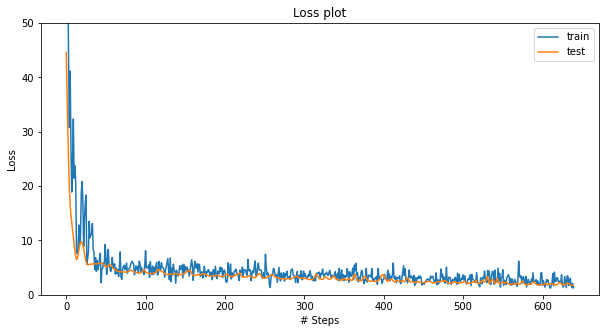

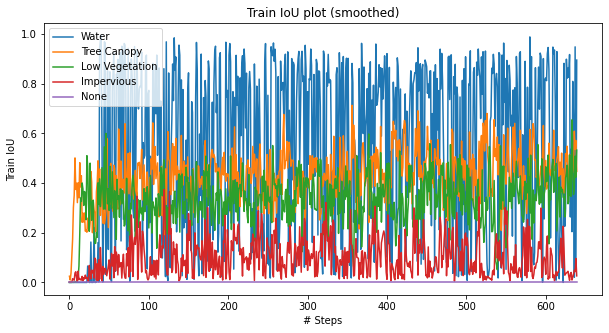

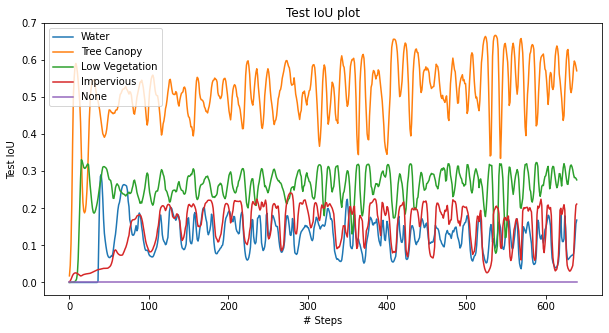

In [ ]:
plot_log(losses, test_losses, IoU, test_IoU, none_flag = True)

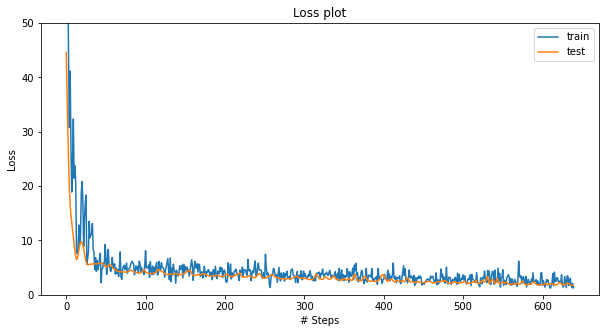

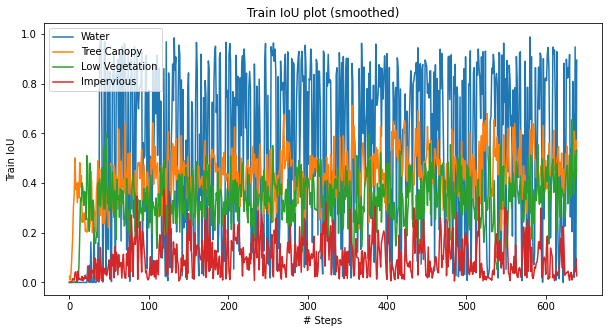

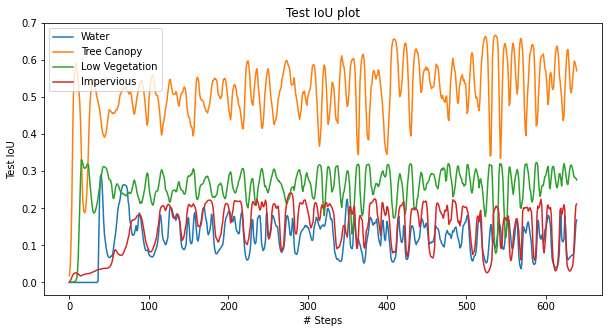

In [ ]:
plot_log(losses, test_losses, IoU, test_IoU, none_flag = False)

In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/basemodels/simple_basemodel')
# model.load_state_dict(torch.load('/content/drive/MyDrive/simple_basemodel'))
# model = model.to(device)

# Visualization of Results

In [ ]:
def make_rgb_label(label_np):
    """
    0: Water, 1: Tree Canopy, 2: Low Vegetation, 3: Impervious
    light blue: Water, dark green: Tree Canopy, light green: Low Vegetation, red: Impervious
    """
    label_np_rgb = np.zeros((len(label_np), 3880, 3880, 3), dtype = np.uint8)
    for i in range(len(label_np)):
        label_np_rgb[i][label_np[i] == 0, :] = [0, 225, 225]
        label_np_rgb[i][label_np[i] == 1, :] = [0, 128, 0]
        label_np_rgb[i][label_np[i] == 2, :] = [0, 225, 0]
        label_np_rgb[i][label_np[i] == 3, :] = [255, 0, 0]

    return(label_np_rgb)

In [ ]:
test_label_loader_rgb = sorted(
    [file for file in os.listdir('/content/drive/MyDrive/Columbia/JPMC3-2/test_label_hr')
    if file.endswith('.npy') & (file.find("rgb") > -1)])
title_1 = re.search('-.*\.', test_label_loader_rgb[0]).group()[1:-1]
title_2 = re.search('-.*\.', test_label_loader_rgb[1]).group()[1:-1]

## Test NAIP image

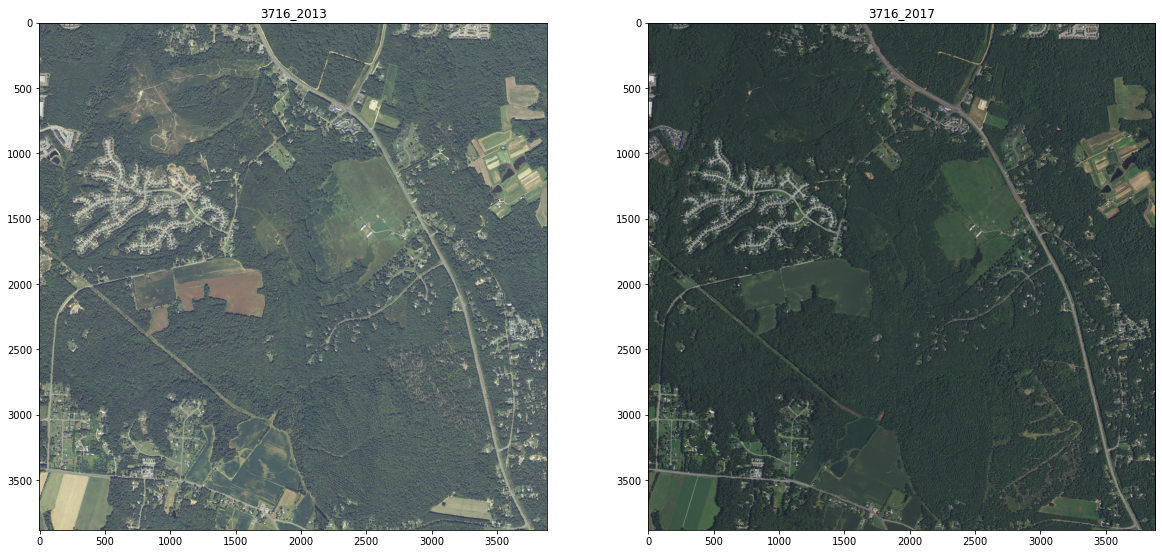

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
ax[0].imshow(np.transpose(test_image_np_s[0], (1, 2, 0))[:, :, :3])
ax[0].set_title(title_1)
ax[1].imshow(np.transpose(test_image_np_s[1], (1, 2, 0))[:, :, :3])
ax[1].set_title(title_2)
plt.show()

## High-resolution manually curated label for test NAIP image (Ground truth)

In [ ]:
hr_label_s_rgb = []
for file in test_label_loader_rgb:
    if file.endswith('.npy'):
        test_label_np_rgb = np.load(
            os.path.join('/content/drive/MyDrive/Columbia/JPMC3-2/test_label_hr', file), gdal.GA_ReadOnly)
        hr_label_s_rgb.append(padding(test_label_np_rgb, rgb_or_gray = "rgb", image_or_label = "label"))

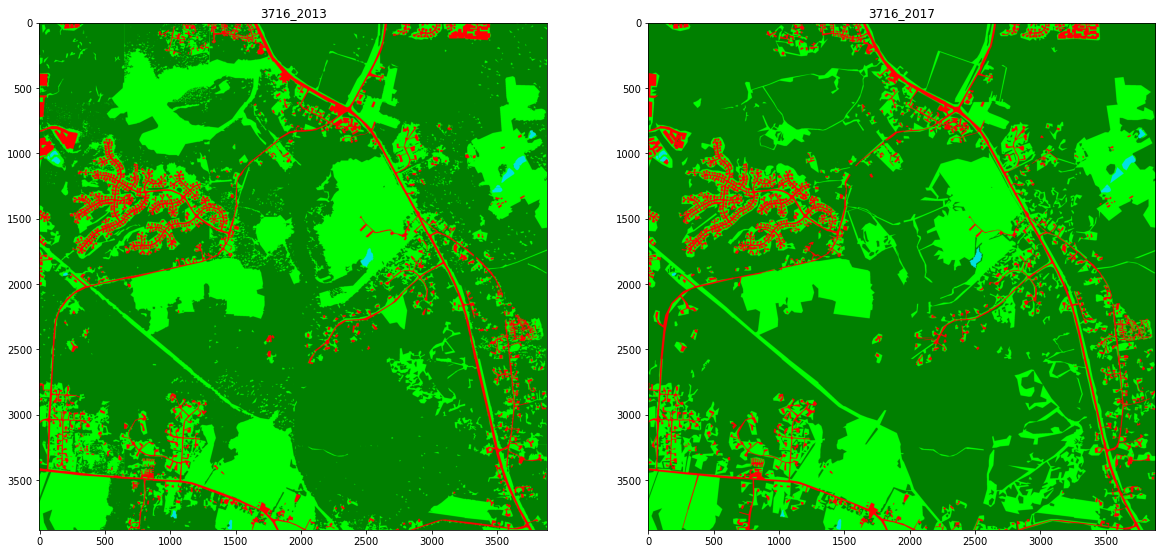

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
ax[0].imshow(hr_label_s_rgb[0])
ax[0].set_title(title_1)
ax[1].imshow(hr_label_s_rgb[1])
ax[1].set_title(title_2)
plt.show()

## Model prediction for Test NAIP image

In [ ]:
test_preds_np_rgb = make_rgb_label(test_preds.to('cpu').detach().numpy().copy())

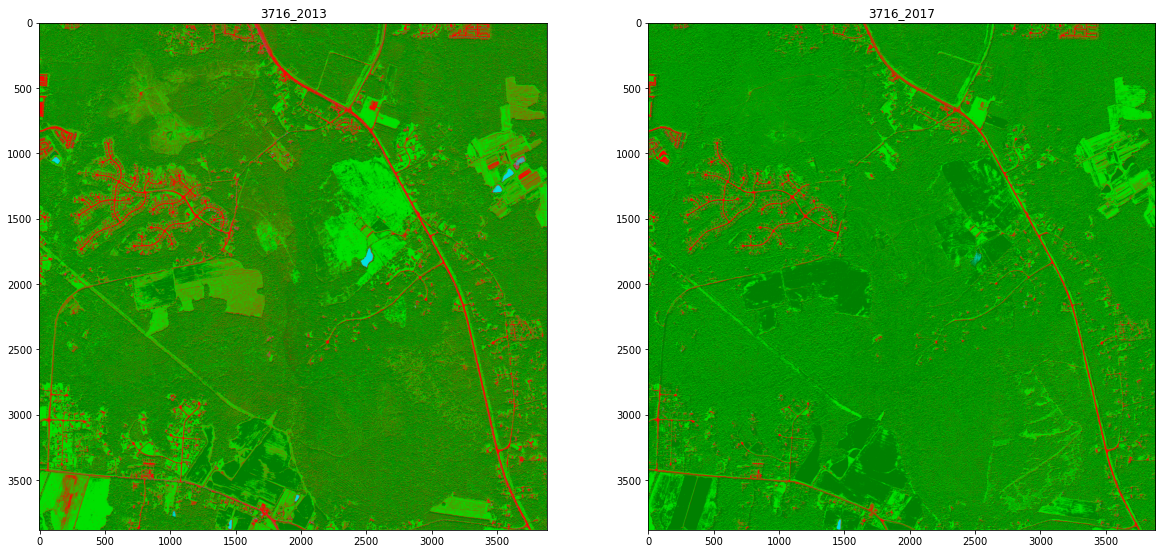

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
ax[0].imshow(test_preds_np_rgb[0])
ax[0].set_title(title_1)
ax[1].imshow(test_preds_np_rgb[1])
ax[1].set_title(title_2)
plt.show()

## Low-resolution label for test NAIP

In [ ]:
#Download the NLCD label .tif file in a folder and set the link to it 
nlcd_np_s = []
test_nlcd_loader = sorted(
    [file for file in os.listdir('/content/drive/MyDrive/Columbia/JPMC3-2/test_label_lr')
     if file.endswith('.tif')])
for file in test_nlcd_loader:
    ds = gdal.Open(os.path.join('/content/drive/MyDrive/Columbia/JPMC3-2/test_label_lr', file), gdal.GA_ReadOnly)
    label_np = np.array([ds.GetRasterBand(i + 1).ReadAsArray() for i in range(ds.RasterCount)])
    label_np = np.squeeze(label_np)
    for i, ele in enumerate(NLCD_CLASSES):
        label_np = np.where(label_np == ele, NLCD_IDX_TO_REDUCED_LC_MAP[i], label_np)

    nlcd_np_s.append(padding(label_np, rgb_or_gray = "gray", image_or_label = "label"))

nlcd_np_s_rgb = make_rgb_label(nlcd_np_s)

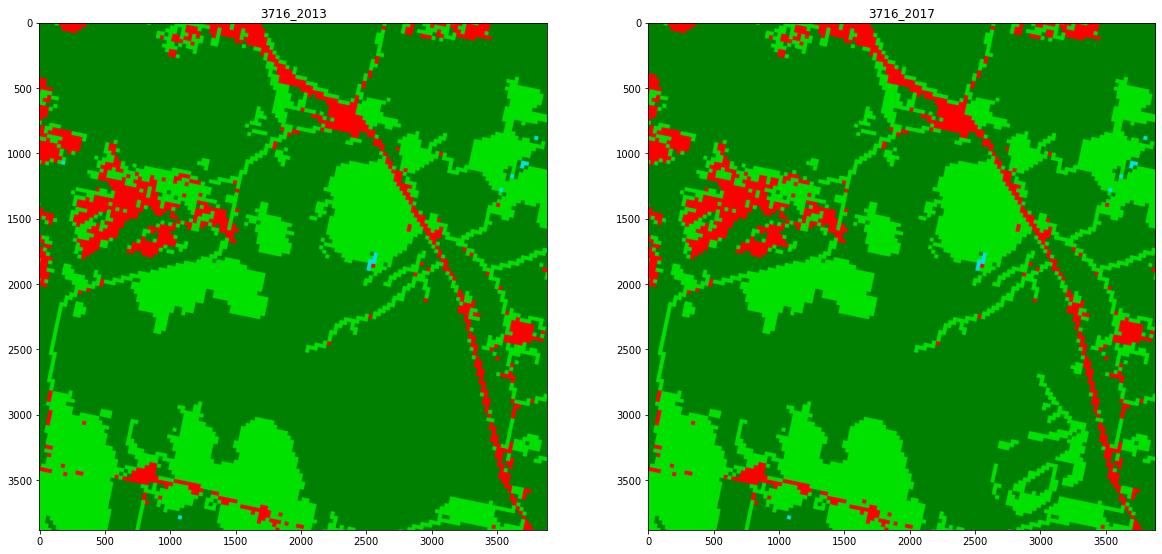

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
ax[0].imshow(nlcd_np_s_rgb[0])
ax[0].set_title(title_1)
ax[1].imshow(nlcd_np_s_rgb[1])
ax[1].set_title(title_2)
plt.show()

## Aligned images

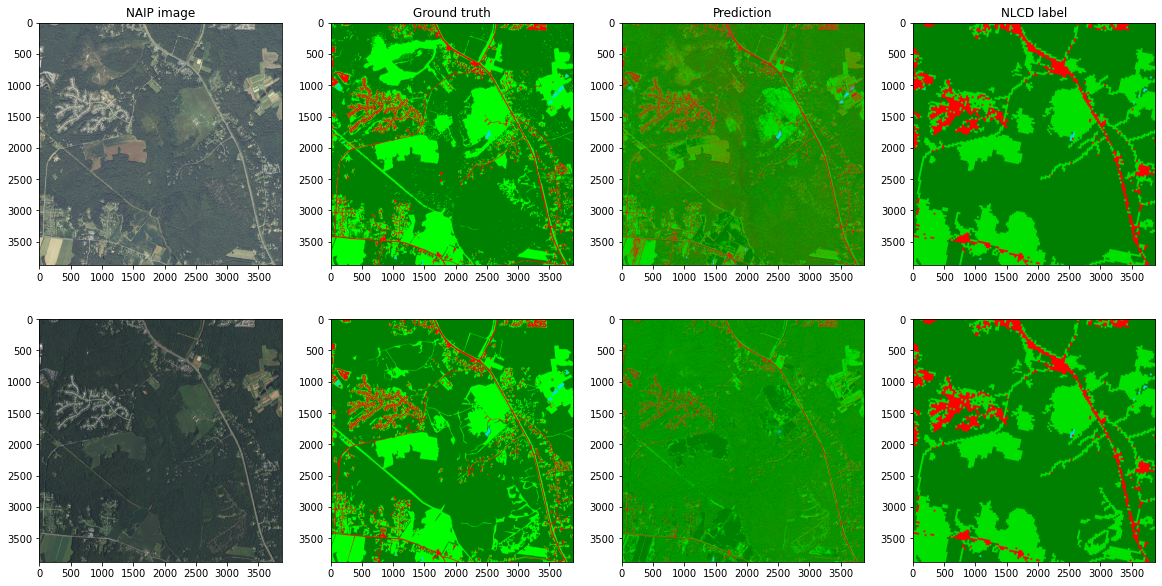

In [ ]:
fig, ax = plt.subplots(2, 4, figsize = (20, 10))
ax[0, 0].set_title('NAIP image')
ax[0, 0].imshow(np.transpose(test_image_np_s[0], (1, 2, 0))[:, :, :3])
ax[1, 0].imshow(np.transpose(test_image_np_s[1], (1, 2, 0))[:, :, :3])
ax[0, 1].set_title('Ground truth')
ax[0, 1].imshow(hr_label_s_rgb[0])
ax[1, 1].imshow(hr_label_s_rgb[1])
ax[0, 2].set_title('Prediction')
ax[0, 2].imshow(test_preds_np_rgb[0])
ax[1, 2].imshow(test_preds_np_rgb[1])
ax[0, 3].set_title('NLCD label')
ax[0, 3].imshow(nlcd_np_s_rgb[0])
ax[1, 3].imshow(nlcd_np_s_rgb[1])
plt.show()

#IoU for Gain and Loss

In [ ]:
def calc_GL_IoU(both_year_preds_np, both_year_true_labels_np):
    by_preds_tensor = torch.tensor(both_year_preds_np + 1)
    by_true_labels_tensor = torch.tensor(both_year_true_labels_np + 1)
    preds_change_flag = by_preds_tensor[0] != by_preds_tensor[1]
    true_change_flag = by_true_labels_tensor[0] != by_true_labels_tensor[1]

    by_preds_tensor[0] = by_preds_tensor[0] * preds_change_flag
    by_preds_tensor[1] = by_preds_tensor[1] * preds_change_flag
    by_true_labels_tensor[0] = by_true_labels_tensor[0] * true_change_flag
    by_true_labels_tensor[1] = by_true_labels_tensor[1] * true_change_flag

    print("preds_change_flag:\n", pd.Series(preds_change_flag.flatten()).value_counts())
    print("\ntrue_change_flag:\n", pd.Series(true_change_flag.flatten()).value_counts())

    print("\n\n0: No Change, 1: -Water, 2: -Tree Canopy, 3: -Low Vegetation, 4: -Impervious, 5: -None",
        "\npred_label_2013:\n", pd.Series(by_preds_tensor[0].flatten()).value_counts(),
        "\n\ntest_label_2013:\n", pd.Series(by_true_labels_tensor[0].flatten()).value_counts())

    print("\n\n0: No Change, 1: +Water, 2: +Tree Canopy, 3: +Low Vegetation, 4: +Impervious, 5: +None",
        "\npred_label_2017:\n", pd.Series(by_preds_tensor[1].flatten()).value_counts(),
        "\n\ntest_label_2017:\n", pd.Series(by_true_labels_tensor[1].flatten()).value_counts())
    
    IoU = []
    for i in range(NUM_DFC2021_CLASS - 1):
        IoU.append(calc_IoU(by_preds_tensor[0], by_true_labels_tensor[0], i + 1).item())
    for i in range(NUM_DFC2021_CLASS - 1):
        IoU.append(calc_IoU(by_preds_tensor[1], by_true_labels_tensor[1], i + 1).item())
    IoU.append(np.mean(IoU))

    print(f"\n\nIoU: [-W, -TC, -LV, -I, +W, +TC, +LV, +I, Avg.] = {np.round(IoU, 3)}")

In [ ]:
test_preds_ch = test_preds.to('cpu').detach().numpy().copy()

calc_GL_IoU(test_preds_ch, test_label_np_s)

preds_change_flag:
 False    7959653
True     7094747
dtype: int64

true_change_flag:
 False    12870326
True      2184074
dtype: int64


0: No Change, 1: -Water, 2: -Tree Canopy, 3: -Low Vegetation, 4: -Impervious, 5: -None 
pred_label_2013:
 0    7959653
3    3317655
4    1869071
2    1845477
1      62394
5        150
dtype: int64 

test_label_2013:
 0    12870326
3     1273116
2      693166
4      214240
1        3552
dtype: int64


0: No Change, 1: +Water, 2: +Tree Canopy, 3: +Low Vegetation, 4: +Impervious, 5: +None 
pred_label_2017:
 0    7959653
2    4305110
3    2366714
4     398638
1      22981
5       1304
dtype: int64 

test_label_2017:
 0    12870326
2     1171683
3      811686
4      197659
1        3046
dtype: int64


IoU: [-W, -TC, -LV, -I, +W, +TC, +LV, +I, Avg.] = [0.022 0.063 0.08  0.032 0.01  0.085 0.064 0.034 0.049]


## IoU for Gain and Loss by NLCD Difference Algorithm 

In [ ]:
calc_GL_IoU(np.array(nlcd_np_s), test_label_np_s)

preds_change_flag:
 False    14835535
True       218865
dtype: int64

true_change_flag:
 False    12870326
True      2184074
dtype: int64


0: No Change, 1: -Water, 2: -Tree Canopy, 3: -Low Vegetation, 4: -Impervious, 5: -None 
pred_label_2013:
 0    14835535
2      199505
3       18482
1         878
dtype: int64 

test_label_2013:
 0    12870326
3     1273116
2      693166
4      214240
1        3552
dtype: int64


0: No Change, 1: +Water, 2: +Tree Canopy, 3: +Low Vegetation, 4: +Impervious, 5: +None 
pred_label_2017:
 0    14835535
3      195255
4       17452
2        6158
dtype: int64 

test_label_2017:
 0    12870326
2     1171683
3      811686
4      197659
1        3046
dtype: int64


IoU: [-W, -TC, -LV, -I, +W, +TC, +LV, +I, Avg.] = [0.    0.106 0.002 0.    0.    0.    0.092 0.003 0.025]


# For my personal work

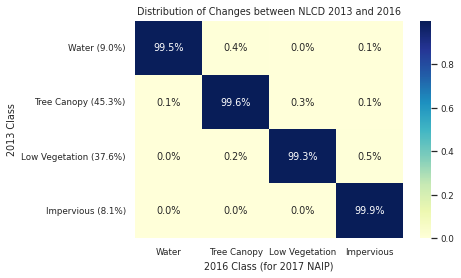

In [ ]:
import seaborn as sns

heatmap_df = pd.DataFrame([[0.995, 0.004, 0.000, 0.001],
                           [0.001, 0.996, 0.003, 0.001],
                           [0.000, 0.002, 0.993, 0.005],
                           [0.000, 0.000, 0.000, 0.999]])
heatmap_df.columns = ["Water", "Tree Canopy", "Low Vegetation", "Impervious"]
heatmap_df.index = ["Water (9.0%)", "Tree Canopy (45.3%)", "Low Vegetation (37.6%)", "Impervious (8.1%)"]
sns.set(font_scale = 0.8)

ax = sns.heatmap(heatmap_df, annot = True, cmap = "YlGnBu", fmt = '.1%')
ax.set_title("Distribution of Changes between NLCD 2013 and 2016")
ax.set_xlabel("2016 Class (for 2017 NAIP)")
ax.set_ylabel("2013 Class")
plt.savefig(f"Distribution of Changes between NLCD 2013 and 2016.png", bbox_inches = 'tight')

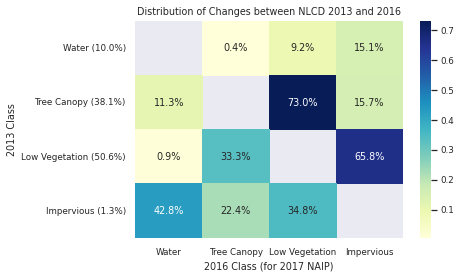

In [ ]:
heatmap_df = pd.DataFrame([[0.000, 0.004, 0.092, 0.151],
                           [0.113, 0.000, 0.730, 0.157],
                           [0.009, 0.333, 0.000, 0.658],
                           [0.428, 0.224, 0.348, 0.000]])
heatmap_df.columns = ["Water", "Tree Canopy", "Low Vegetation", "Impervious"]
heatmap_df.index = ["Water (10.0%)", "Tree Canopy (38.1%)", "Low Vegetation (50.6%)", "Impervious (1.3%)"]
sns.set(font_scale = 0.8)

ax = sns.heatmap(heatmap_df, annot = True, cmap = "YlGnBu", fmt = '.1%', mask = np.eye(len(heatmap_df)))
ax.set_title("Distribution of Changes between NLCD 2013 and 2016")
ax.set_xlabel("2016 Class (for 2017 NAIP)")
ax.set_ylabel("2013 Class")
plt.savefig(f"Distribution of Changes between NLCD 2013 and 2016 without diag.png", bbox_inches = 'tight')